## Mini Project 2

I will explore the prject trasition by fitting a Dynamic Topic Model (DTM) using Gensim.

#### Data cleaning

In [117]:
from gensim.models import LdaSeqModel
from ipywidgets import interact
import pyLDAvis
import pandas as pd
import dtm # custom module
import matplotlib.pyplot as plt


# read in file
data = pd.read_csv('IDB archive.csv')
# select only the columns we need
data = data.loc[:, ['Date', 'Sector', 'Description']]
data

,Date,Sector,Description
0,NaN,HEALTH,The objective of the second individual loan op...
1,NaN,SUSTAINABLE TOURISM,The general objectives of the program are to i...
2,NaN,ENVIRONMENT AND NATURAL DISASTERS,The objective of the programmatic policy-based...
3,NaN,OTHER,The objective of this technical cooperation (T...
4,NaN,ENERGY,The general objective of this Technical Cooper...
...,...,...,...
17903,2-Jul-93,NaN,NaN
17904,30-Jun-93,FINANCIAL MARKETS,THE MAIN OBJECTIVE IS TO STRENGTHEN AND ACCELE...
17905,29-Jun-93,PRIVATE FIRMS AND SME DEVELOPMENT,"INSTITUTIONAL STRENGTHENING OF COOPEBRISAS,IMP..."
17906,29-Jun-93,PRIVATE FIRMS AND SME DEVELOPMENT,"INSTITUTIONAL STRENGTHENING, IMPROVEMENT AND C..."


In [118]:
# remove na in Sector or Description
data = data.dropna(subset=['Sector', 'Description'])
# filter out if Decription contains to little info
data = data.loc[data['Description'].str.len() > 10] # data = data.loc[data['Description'] != 'EN']
# fill rows without a date a 2021 data
data['Date'] = data['Date'].fillna('01-Oct-21')
# read in the date format
data['Date'] = pd.to_datetime(data.Date, format='%d-%b-%y')
# construct a year column
data['Year'] = pd.DatetimeIndex(data['Date']).year.astype(int)
# select again the columns we need
data = data.loc[:, ['Year', 'Sector', 'Description']]
# get the time inverval in 2000, 2010, 2020
data = data.loc[data['Year'].isin((2000, 2010, 2020))]
# change into ascending order
data = data[::-1]

In [119]:
# aggregate some sectors
energy = data.loc[data['Sector'] == 'ENERGY']
environment = data.loc[data['Sector'] == 'ENVIRONMENT AND NATURAL DISASTERS']
sci_and_tech = data.loc[data['Sector'] == 'SCIENCE AND TECHNOLOGY']
social_investment = data.loc[data['Sector'] == 'SOCIAL INVESTMENT']
transport = data.loc[data['Sector'] == 'TRANSPORT']

#### See the data distribution in each decade

In [120]:
energy.groupby('Year')['Description'].count()

Year
2000     7
2010    47
2020    41
Name: Description, dtype: int64

In [121]:
environment.groupby('Year')['Description'].count()

Year
2000    22
2010    65
2020    56
Name: Description, dtype: int64

In [122]:
sci_and_tech.groupby('Year')['Description'].count()

Year
2000     8
2010    31
2020    21
Name: Description, dtype: int64

In [123]:
social_investment.groupby('Year')['Description'].count()

Year
2000    18
2010    56
2020    74
Name: Description, dtype: int64

In [124]:
transport.groupby('Year')['Description'].count()

Year
2000     7
2010    52
2020    27
Name: Description, dtype: int64

#### Sector: Energy

Stem, tokenize, and prepare the data

In [154]:
stemmed_tokens = dtm.tokenize(energy['Description']) # clean text and tokenize and stem it

stemmed_tokens.head()

14443    [oper, oversight, regulatori, plan, function, ...
14434    [propos, first, phase, feasibl, studi, sulphur...
14264    [design, train, program, regulatori, agent, ar...
14138    [assist, carri, feasibl, studi, strengthen, ex...
14129    [studi, undertaken, prefeas, studi, whose, ana...
Name: Description, dtype: object

In [155]:
dictionary, bow_corpus = dtm.prepare_data(stemmed_tokens)

In [156]:
time_slice = energy.groupby('Year')['Description'].count().to_list()
time_slice

[7, 47, 41]

Decide the best number of topics by calculating the coherence

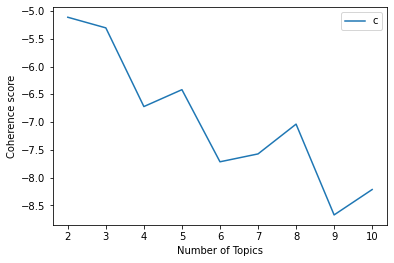

In [12]:
model_list, coherence_values = dtm.compute_coherence_values(dictionary=dictionary,
                                                           corpus=bow_corpus,
                                                           texts=stemmed_tokens,
                                                           start=2,
                                                           limit=11,
                                                           step=1)
plt.plot(range(2, 11, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

In [13]:
# fit model
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=2)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


generate a coherence score for the topics ***at each time slice***

In [14]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

Coherence at Time Slice 0: -5.303894604632175
Coherence at Time Slice 1: -5.251445691189986
Coherence at Time Slice 2: -5.190039844515326
Average Coherence:  -5.2484600467791624


The default DTM remains mostly the same over time with only few minor variations

In [15]:
dtm.print_dtm(ldaseq, n_topics=2, n_time_slices=3)

##### Topic 0, Time Slice 0 #####
['oper', 'project', 'cooper', 'provid', 'effici', 'capac', 'studi', 'object', 'sustain', 'servic']
##### Topic 0, Time Slice 1 #####
['oper', 'project', 'cooper', 'provid', 'effici', 'capac', 'studi', 'object', 'sustain', 'servic']
##### Topic 0, Time Slice 2 #####
['oper', 'project', 'cooper', 'effici', 'provid', 'capac', 'object', 'studi', 'sustain', 'servic']


##### Topic 1, Time Slice 0 #####
['contribut', 'use', 'studi', 'sustain', 'promot', 'term', 'action', 'identifi', 'area', 'haiti']
##### Topic 1, Time Slice 1 #####
['contribut', 'use', 'studi', 'sustain', 'promot', 'term', 'action', 'area', 'identifi', 'haiti']
##### Topic 1, Time Slice 2 #####
['contribut', 'use', 'studi', 'sustain', 'promot', 'action', 'term', 'area', 'identifi', 'haiti']




In [16]:
# save to/load from file:
ldaseq.save('dtm.model_1')

# ldaseq = LdaSeqModel.load('dtm.model_1')

tweak the variance parameter so that topics are allowed to change more between time slices

In [17]:
# train model with higher chain variance (e.g. topics are allowed to change more between time slices)
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=2,
                     chain_variance=0.5)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [18]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

dtm.print_dtm(ldaseq, n_topics=2, n_time_slices=3)

Coherence at Time Slice 0: -5.925686018863983
Coherence at Time Slice 1: -6.786079927891453
Coherence at Time Slice 2: -5.406457680744179
Average Coherence:  -6.039407875833206
##### Topic 0, Time Slice 0 #####
['communiti', 'rural', 'provid', 'term', 'plan', 'assist', 'use', 'cooper', 'system', 'long']
##### Topic 0, Time Slice 1 #####
['term', 'communiti', 'provid', 'use', 'long', 'haiti', 'activ', 'grant', 'includ', 'plan']
##### Topic 0, Time Slice 2 #####
['cooper', 'sector', 'natur', 'oper', 'contribut', 'object', 'use', 'build', 'propos', 'impact']


##### Topic 1, Time Slice 0 #####
['studi', 'project', 'servic', 'econom', 'market', 'work', 'capac', 'object', 'regulatori', 'use']
##### Topic 1, Time Slice 1 #####
['studi', 'sustain', 'reduc', 'project', 'environment', 'promot', 'econom', 'contribut', 'area', 'compon']
##### Topic 1, Time Slice 2 #####
['contribut', 'project', 'promot', 'cooper', 'sustain', 'econom', 'oper', 'studi', 'environment', 'prepar']




In [19]:
# optionally, save to/load from file:
ldaseq.save('dtm_var5.model_1')

# ldaseq = LdaSeqModel.load('dtm_var5.model_1')

In [157]:
topic_weights = pd.DataFrame([ldaseq.doc_topics(j) for j in range(len(bow_corpus))],
                             columns=['topic0', 'topic1'])
df = energy.reset_index() \
            .merge(topic_weights,
                   left_index=True,
                   right_index=True)
df.head()

,index,Year,Sector,Description,topic0,topic1
0,14443,2000,ENERGY,The general objective of this operation is to ...,0.000370,0.999630
1,14434,2000,ENERGY,The objective of the proposed project is to su...,0.000907,0.999093
2,14264,2000,ENERGY,The specific objective is to support the desig...,0.000333,0.999667
3,14138,2000,ENERGY,The objective of the technical assistance is t...,0.001247,0.998753
4,14129,2000,ENERGY,The study that will be undertaken is a pre-fea...,0.000137,0.999863


visualization with pyLDAvis

In [158]:
pyLDAvis.enable_notebook()

# Create pyLDAvis visualization for each year:
vis = {}
dates = pd.Series(['2000', '2010', '2020'])
for i in range(3):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                            doc_topic_dists=doc_topic,
                                            doc_lengths=doc_lengths,
                                            vocab=vocab,
                                            term_frequency=term_frequency)

# Make an interactive plot so we can cycle through topics by year:
@interact(Year=dates)
def f(Year):
    return vis[Year]

# optionally save
#for i in range(len(time_slice)):
#    pyLDAvis.save_html(vis[dates[i]], 'lda_t{}.html'.format(i))

interactive(children=(Dropdown(description='Year', options=('2000', '2010', '2020'), value='2000'), Output()),…

#### Sector: Environment

In [125]:
stemmed_tokens = dtm.tokenize(environment['Description']) # clean text and tokenize and stem it

stemmed_tokens.head()

14469    [improv, environment, safer, dispos, solid, wa...
14468    [oper, feasibl, plan, recuper, approxim, hecta...
14429    [loan, resourc, urgent, activ, remov, debri, d...
14400    [perform, basic, studi, design, guarante, fund...
14398    [global, esnacifor, region, train, center, for...
Name: Description, dtype: object

In [126]:
dictionary, bow_corpus = dtm.prepare_data(stemmed_tokens)

In [127]:
time_slice = environment.groupby('Year')['Description'].count().to_list()
time_slice

[22, 65, 56]

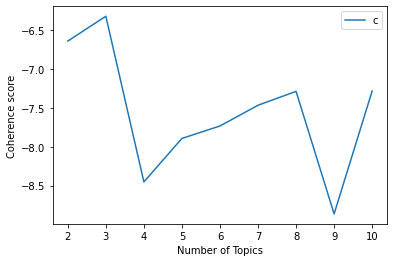

In [41]:
model_list, coherence_values = dtm.compute_coherence_values(dictionary=dictionary,
                                                           corpus=bow_corpus,
                                                           texts=stemmed_tokens,
                                                           start=2,
                                                           limit=11,
                                                           step=1)
plt.plot(range(2, 11, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

In [140]:
# fit model
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=3)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


generate a coherence score for the topics ***at each time slice***

In [141]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

Coherence at Time Slice 0: -4.78013160007911
Coherence at Time Slice 1: -4.777939486268504
Coherence at Time Slice 2: -4.778104943600908
Average Coherence:  -4.778725343316174


In [142]:
dtm.print_dtm(ldaseq, n_topics=3, n_time_slices=3)

##### Topic 0, Time Slice 0 #####
['climat', 'chang', 'manag', 'adapt', 'nation', 'capac', 'sustain', 'promot', 'oper', 'institut']
##### Topic 0, Time Slice 1 #####
['climat', 'chang', 'manag', 'adapt', 'nation', 'capac', 'sustain', 'promot', 'oper', 'institut']
##### Topic 0, Time Slice 2 #####
['climat', 'chang', 'manag', 'nation', 'adapt', 'capac', 'sustain', 'promot', 'oper', 'institut']


##### Topic 1, Time Slice 0 #####
['manag', 'provid', 'polici', 'risk', 'institut', 'coastal', 'loan', 'oper', 'disast', 'resili']
##### Topic 1, Time Slice 1 #####
['manag', 'provid', 'polici', 'risk', 'institut', 'coastal', 'loan', 'oper', 'disast', 'resili']
##### Topic 1, Time Slice 2 #####
['manag', 'provid', 'polici', 'risk', 'institut', 'coastal', 'loan', 'oper', 'disast', 'resili']


##### Topic 2, Time Slice 0 #####
['humanitarian', 'affect', 'cooper', 'environment', 'assist', 'action', 'emerg', 'sustain', 'inform', 'popul']
##### Topic 2, Time Slice 1 #####
['affect', 'humanitarian', '

In [143]:
# save to/load from file:
ldaseq.save('dtm.model_2')

# ldaseq = LdaSeqModel.load('dtm.model_2')

tweak the variance parameter so that topics are allowed to change more between time slices

In [148]:
# train model with higher chain variance (e.g. topics are allowed to change more between time slices)
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=3,
                     chain_variance=0.5)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [149]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

dtm.print_dtm(ldaseq, n_topics=3, n_time_slices=3)

Coherence at Time Slice 0: -4.253948718025196
Coherence at Time Slice 1: -4.211849817354959
Coherence at Time Slice 2: -5.876144008497239
Average Coherence:  -4.780647514625798
##### Topic 0, Time Slice 0 #####
['environment', 'manag', 'servic', 'smes', 'forest', 'suppli', 'plan', 'cp', 'demand', 'promot']
##### Topic 0, Time Slice 1 #####
['forest', 'manag', 'environment', 'sustain', 'communiti', 'nation', 'action', 'plan', 'cooper', 'humanitarian']
##### Topic 0, Time Slice 2 #####
['sustain', 'forest', 'manag', 'provid', 'deforest', 'environment', 'use', 'nation', 'platform', 'plan']


##### Topic 1, Time Slice 0 #####
['state', 'manag', 'prepar', 'sustain', 'oper', 'acr', 'cooper', 'environment', 'activ', 'climat']
##### Topic 1, Time Slice 1 #####
['climat', 'chang', 'manag', 'institut', 'mitig', 'cooper', 'polici', 'assist', 'provid', 'promot']
##### Topic 1, Time Slice 2 #####
['humanitarian', 'affect', 'assist', 'oper', 'emerg', 'cooper', 'tropic', 'provis', 'polici', 'nation']

In [150]:
# optionally, save to/load from file:
ldaseq.save('dtm_var5.model_2')

# ldaseq = LdaSeqModel.load('dtm_var5.model_2')

In [151]:
topic_weights = pd.DataFrame([ldaseq.doc_topics(j) for j in range(len(bow_corpus))],
                             columns=['topic0', 'topic1', 'topic2'])
df = environment.reset_index() \
            .merge(topic_weights,
                   left_index=True,
                   right_index=True)
df.head()

,index,Year,Sector,Description,topic0,topic1,topic2
0,14469,2000,ENVIRONMENT AND NATURAL DISASTERS,TO SUPPORT AN IMPROVED AND ENVIRONMENTALLY SAF...,0.000831,0.998337,0.000831
1,14468,2000,ENVIRONMENT AND NATURAL DISASTERS,The objective of the operation is to develop a...,0.000192,0.000192,0.999616
2,14429,2000,ENVIRONMENT AND NATURAL DISASTERS,LOAN RESOURCES WILL FINANCE URGENT ACTIVITIES ...,0.000384,0.643420,0.356196
3,14400,2000,ENVIRONMENT AND NATURAL DISASTERS,Perform the basic studies to support the desig...,0.000256,0.999488,0.000256
4,14398,2000,ENVIRONMENT AND NATURAL DISASTERS,The global objective of this TC is to develop ...,0.001422,0.997155,0.001422


visualization with pyLDAvis

In [152]:
pyLDAvis.enable_notebook()

# Create pyLDAvis visualization for each year:
vis = {}
dates = pd.Series(['2000', '2010', '2020'])
for i in range(3):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                            doc_topic_dists=doc_topic,
                                            doc_lengths=doc_lengths,
                                            vocab=vocab,
                                            term_frequency=term_frequency)

# Make an interactive plot so we can cycle through topics by year:
@interact(Year=dates)
def f(Year):
    return vis[Year]

# optionally save
#for i in range(len(time_slice)):
#    pyLDAvis.save_html(vis[dates[i]], 'lda_t{}.html'.format(i))

interactive(children=(Dropdown(description='Year', options=('2000', '2010', '2020'), value='2000'), Output()),…

#### Sector: Science and Technology

In [165]:
stemmed_tokens = dtm.tokenize(sci_and_tech['Description']) # clean text and tokenize and stem it

stemmed_tokens.head()

14403                             [cultur, land, use, gis]
14261    [modern, telecommun, competit, telecommun, fiv...
14249    [evalu, replic, extens, pilot, teach, mathemat...
14093    [intern, takeoff, citi, knowledg, bank, focus,...
14046    [contribut, provis, assist, bank, region, oper...
Name: Description, dtype: object

In [166]:
dictionary, bow_corpus = dtm.prepare_data(stemmed_tokens)

In [167]:
time_slice = sci_and_tech.groupby('Year')['Description'].count().to_list()
time_slice

[8, 31, 21]

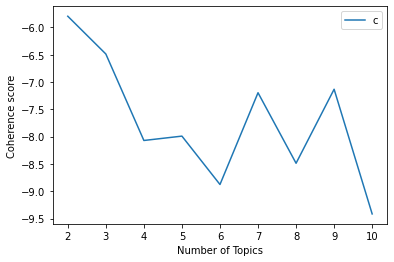

In [55]:
model_list, coherence_values = dtm.compute_coherence_values(dictionary=dictionary,
                                                           corpus=bow_corpus,
                                                           texts=stemmed_tokens,
                                                           start=2,
                                                           limit=11,
                                                           step=1)
plt.plot(range(2, 11, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

In [56]:
# fit model
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=2)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


generate a coherence score for the topics ***at each time slice***

In [57]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

Coherence at Time Slice 0: -4.978790591059821
Coherence at Time Slice 1: -4.981500115841877
Coherence at Time Slice 2: -5.033705086627694
Average Coherence:  -4.997998597843131


In [58]:
dtm.print_dtm(ldaseq, n_topics=2, n_time_slices=3)

##### Topic 0, Time Slice 0 #####
['innov', 'digit', 'product', 'promot', 'strengthen', 'contribut', 'public', 'sector', 'institut', 'competit']
##### Topic 0, Time Slice 1 #####
['innov', 'digit', 'product', 'promot', 'strengthen', 'contribut', 'public', 'sector', 'institut', 'competit']
##### Topic 0, Time Slice 2 #####
['innov', 'digit', 'product', 'promot', 'strengthen', 'public', 'contribut', 'institut', 'sector', 'competit']


##### Topic 1, Time Slice 0 #####
['innov', 'inform', 'nation', 'polici', 'capac', 'use', 'knowledg', 'access', 'new', 'product']
##### Topic 1, Time Slice 1 #####
['innov', 'inform', 'nation', 'polici', 'capac', 'use', 'knowledg', 'new', 'access', 'product']
##### Topic 1, Time Slice 2 #####
['innov', 'nation', 'inform', 'polici', 'capac', 'knowledg', 'use', 'new', 'access', 'product']




In [59]:
# save to/load from file:
ldaseq.save('dtm.model_3')

# ldaseq = LdaSeqModel.load('dtm.model_3')

tweak the variance parameter so that topics are allowed to change more between time slices

In [60]:
# train model with higher chain variance (e.g. topics are allowed to change more between time slices)
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=2,
                     chain_variance=0.5)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [61]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

dtm.print_dtm(ldaseq, n_topics=2, n_time_slices=3)

Coherence at Time Slice 0: -6.54112192180231
Coherence at Time Slice 1: -5.440572889714529
Coherence at Time Slice 2: -5.343929015037043
Average Coherence:  -5.775207942184626
##### Topic 0, Time Slice 0 #####
['export', 'product', 'sector', 'inform', 'competit', 'innov', 'use', 'activ', 'polici', 'servic']
##### Topic 0, Time Slice 1 #####
['polici', 'innov', 'use', 'product', 'inform', 'institut', 'competit', 'access', 'design', 'new']
##### Topic 0, Time Slice 2 #####
['innov', 'polici', 'product', 'promot', 'digit', 'public', 'institut', 'servic', 'cluster', 'design']


##### Topic 1, Time Slice 0 #####
['better', 'innov', 'center', 'manag', 'inclus', 'cdi', 'digit', 'enterpris', 'sustain', 'cooper']
##### Topic 1, Time Slice 1 #####
['innov', 'nation', 'capac', 'strategi', 'knowledg', 'area', 'educ', 'digit', 'contribut', 'inclus']
##### Topic 1, Time Slice 2 #####
['capac', 'digit', 'promot', 'economi', 'innov', 'nation', 'knowledg', 'inclus', 'lac', 'strategi']




In [62]:
# optionally, save to/load from file:
ldaseq.save('dtm_var5.model_3')

# ldaseq = LdaSeqModel.load('dtm_var5.model_3')

In [169]:
topic_weights = pd.DataFrame([ldaseq.doc_topics(j) for j in range(len(bow_corpus))],
                             columns=['topic0', 'topic1'])
df = sci_and_tech.reset_index() \
            .merge(topic_weights,
                   left_index=True,
                   right_index=True)
df.head()

,index,Year,Sector,Description,topic0,topic1
0,14403,2000,SCIENCE AND TECHNOLOGY,TO DEVELOP A PROGRAM OF CULTURAL LAND USE GIS.,0.002488,0.997512
1,14261,2000,SCIENCE AND TECHNOLOGY,This project to modernize the telecommunicatio...,0.999722,0.000278
2,14249,2000,SCIENCE AND TECHNOLOGY,1) To evaluate the replicability and extension...,0.998891,0.001109
3,14093,2000,SCIENCE AND TECHNOLOGY,A PROGRAM TO SUPPORT THE INTERNATIONAL TAKE-OF...,0.000500,0.999500
4,14046,2000,SCIENCE AND TECHNOLOGY,TO CONTRIBUTE IN THE PROVISION OF TECHNICAL AS...,0.999376,0.000624


visualization with pyLDAvis

In [170]:
pyLDAvis.enable_notebook()

# Create pyLDAvis visualization for each year:
vis = {}
dates = pd.Series(['2000', '2010', '2020'])
for i in range(3):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                            doc_topic_dists=doc_topic,
                                            doc_lengths=doc_lengths,
                                            vocab=vocab,
                                            term_frequency=term_frequency)

# Make an interactive plot so we can cycle through topics by year:
@interact(Year=dates)
def f(Year):
    return vis[Year]

# optionally save
#for i in range(len(time_slice)):
#    pyLDAvis.save_html(vis[dates[i]], 'lda_t{}.html'.format(i))

interactive(children=(Dropdown(description='Year', options=('2000', '2010', '2020'), value='2000'), Output()),…

#### Sector: Social Investment

In [171]:
stemmed_tokens = dtm.tokenize(social_investment['Description']) # clean text and tokenize and stem it

stemmed_tokens.head()

14411    [consult, bank, strategi, elder, interest, pro...
14386    [object, capabl, adecu, inform, design, follow...
14371    [labormanag, relat, brazil, train, program, en...
14366    [consult, bank, strategi, elder, interest, pro...
14341    [object, qualiti, life, entir, famili, especi,...
Name: Description, dtype: object

In [172]:
dictionary, bow_corpus = dtm.prepare_data(stemmed_tokens)

In [173]:
time_slice = social_investment.groupby('Year')['Description'].count().to_list()
time_slice

[18, 56, 74]

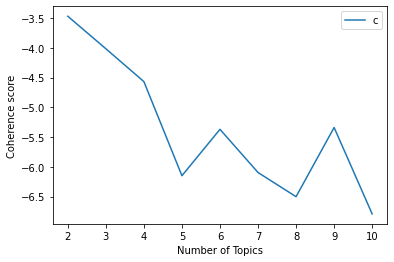

In [68]:
model_list, coherence_values = dtm.compute_coherence_values(dictionary=dictionary,
                                                           corpus=bow_corpus,
                                                           texts=stemmed_tokens,
                                                           start=2,
                                                           limit=11,
                                                           step=1)
plt.plot(range(2, 11, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

In [69]:
# fit model
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=2)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


generate a coherence score for the topics ***at each time slice***

In [70]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

Coherence at Time Slice 0: -3.8762196872271257
Coherence at Time Slice 1: -3.8802915693609052
Coherence at Time Slice 2: -3.878719675609429
Average Coherence:  -3.878410310732486


In [71]:
dtm.print_dtm(ldaseq, n_topics=2, n_time_slices=3)

##### Topic 0, Time Slice 0 #####
['labor', 'level', 'crisi', 'incom', 'minimum', 'qualiti', 'polici', 'employ', 'peopl', 'famili']
##### Topic 0, Time Slice 1 #####
['labor', 'level', 'crisi', 'incom', 'minimum', 'qualiti', 'polici', 'employ', 'peopl', 'contribut']
##### Topic 0, Time Slice 2 #####
['labor', 'level', 'crisi', 'incom', 'minimum', 'qualiti', 'employ', 'polici', 'peopl', 'covid']


##### Topic 1, Time Slice 0 #####
['servic', 'train', 'polici', 'design', 'promot', 'provid', 'health', 'cooper', 'program', 'capac']
##### Topic 1, Time Slice 1 #####
['servic', 'polici', 'train', 'design', 'promot', 'provid', 'health', 'cooper', 'strengthen', 'public']
##### Topic 1, Time Slice 2 #####
['servic', 'polici', 'design', 'train', 'promot', 'provid', 'health', 'cooper', 'public', 'strengthen']




In [72]:
# optionally, save to/load from file:
ldaseq.save('dtm.model_4')

# ldaseq = LdaSeqModel.load('dtm.model_4')

tweak the variance parameter so that topics are allowed to change more between time slices

In [73]:
# train model with higher chain variance (e.g. topics are allowed to change more between time slices)
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=2,
                     chain_variance=0.5)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [74]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

dtm.print_dtm(ldaseq, n_topics=2, n_time_slices=3)

Coherence at Time Slice 0: -4.226245245197035
Coherence at Time Slice 1: -3.904112948126955
Coherence at Time Slice 2: -3.0573261155782143
Average Coherence:  -3.729228102967401
##### Topic 0, Time Slice 0 #####
['local', 'famili', 'violenc', 'program', 'object', 'gender', 'project', 'poverti', 'assist', 'govern']
##### Topic 0, Time Slice 1 #####
['oper', 'contribut', 'polici', 'process', 'gender', 'program', 'strengthen', 'poverti', 'institut', 'monitor']
##### Topic 0, Time Slice 2 #####
['labor', 'strengthen', 'polici', 'institut', 'promot', 'oper', 'gender', 'qualiti', 'contribut', 'program']


##### Topic 1, Time Slice 0 #####
['train', 'design', 'evalu', 'program', 'provid', 'partner', 'knowledg', 'servic', 'polici', 'labor']
##### Topic 1, Time Slice 1 #####
['evalu', 'polici', 'program', 'health', 'servic', 'labor', 'design', 'effect', 'household', 'impact']
##### Topic 1, Time Slice 2 #####
['covid', 'level', 'crisi', 'minimum', 'design', 'vulner', 'servic', 'peopl', 'health'

In [75]:
# optionally, save to/load from file:
ldaseq.save('dtm_var5.model_4')

# ldaseq = LdaSeqModel.load('dtm_var5.model_4')

In [76]:
topic_weights = pd.DataFrame([ldaseq.doc_topics(j) for j in range(len(bow_corpus))],
                             columns=['topic0', 'topic1'])
df = social_investment.reset_index() \
            .merge(topic_weights,
                   left_index=True,
                   right_index=True)
df.head()

,index,Year,Sector,Description,topic0,topic1
0,14411,2000,SOCIAL INVESTMENT,CONSULTANCIES TO SUPPORT THE DEVELOPMENT BY TH...,0.998575,0.001425
1,14386,2000,SOCIAL INVESTMENT,The objectives of the Program is to improve th...,0.602097,0.397903
2,14371,2000,SOCIAL INVESTMENT,To improve labor-management relations in Brazi...,0.000907,0.999093
3,14366,2000,SOCIAL INVESTMENT,CONSULTANCIES TO SUPPORT THE DEVELOPMENT BY TH...,0.998575,0.001425
4,14341,2000,SOCIAL INVESTMENT,The general objectives of the project are to (...,0.999808,0.000192


visualization with pyLDAvis

In [175]:
pyLDAvis.enable_notebook()

# Create pyLDAvis visualization for each year:
vis = {}
dates = pd.Series(['2000', '2010', '2020']) # grab two topic distribution from two time slices
for i in range(3):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                            doc_topic_dists=doc_topic,
                                            doc_lengths=doc_lengths,
                                            vocab=vocab,
                                            term_frequency=term_frequency)

# Make an interactive plot so we can cycle through topics by year:
@interact(Year=dates)
def f(Year):
    return vis[Year]

# optionally save
#for i in range(len(time_slice)):
#    pyLDAvis.save_html(vis[dates[i]], 'lda_t{}.html'.format(i))

interactive(children=(Dropdown(description='Year', options=('2000', '2010', '2020'), value='2000'), Output()),…

#### Sector: Transportation

In [177]:
stemmed_tokens = dtm.tokenize(transport['Description']) # clean text and tokenize and stem it

stemmed_tokens.head()

14433    [princip, cooper, assist, viceministerio, tran...
14390    [project, give, strength, continu, environment...
14331        [project, transport, infrastructur, communic]
14162    [repair, reconstruct, facil, road, seawal, bri...
14054    [network, western, part, paraguay, facilit, re...
Name: Description, dtype: object

In [178]:
dictionary, bow_corpus = dtm.prepare_data(stemmed_tokens)

In [179]:
time_slice = transport.groupby('Year')['Description'].count().to_list()
time_slice

[7, 52, 27]

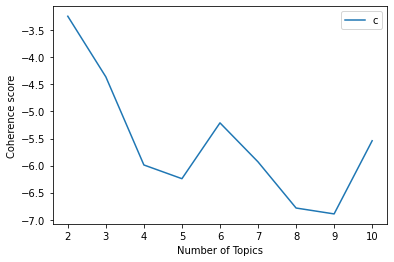

In [91]:
model_list, coherence_values = dtm.compute_coherence_values(dictionary=dictionary,
                                                           corpus=bow_corpus,
                                                           texts=stemmed_tokens,
                                                           start=2,
                                                           limit=11,
                                                           step=1)
plt.plot(range(2, 11, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

In [92]:
# fit model
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=2)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


generate a coherence score for the topics ***at each time slice***

In [93]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

Coherence at Time Slice 0: -3.5745520448562917
Coherence at Time Slice 1: -3.573284049890785
Coherence at Time Slice 2: -3.578439961003067
Average Coherence:  -3.575425351916715


In [94]:
dtm.print_dtm(ldaseq, n_topics=2, n_time_slices=3)

##### Topic 0, Time Slice 0 #####
['oper', 'public', 'reduc', 'network', 'transport', 'safeti', 'mobil', 'cooper', 'sustain', 'ministri']
##### Topic 0, Time Slice 1 #####
['oper', 'public', 'reduc', 'network', 'transport', 'safeti', 'mobil', 'cooper', 'sustain', 'ministri']
##### Topic 0, Time Slice 2 #####
['public', 'oper', 'reduc', 'network', 'transport', 'mobil', 'safeti', 'cooper', 'ministri', 'sustain']


##### Topic 1, Time Slice 0 #####
['plan', 'logist', 'region', 'environment', 'manag', 'studi', 'public', 'includ', 'sustain', 'institut']
##### Topic 1, Time Slice 1 #####
['plan', 'logist', 'region', 'environment', 'manag', 'studi', 'public', 'sustain', 'includ', 'institut']
##### Topic 1, Time Slice 2 #####
['plan', 'logist', 'region', 'environment', 'manag', 'studi', 'public', 'includ', 'sustain', 'institut']




In [95]:
# optionally, save to/load from file:
ldaseq.save('dtm.model_5')

# ldaseq = LdaSeqModel.load('dtm.model_5')

tweak the variance parameter so that topics are allowed to change more between time slices

In [96]:
# train model with higher chain variance (e.g. topics are allowed to change more between time slices)
ldaseq = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=2,
                     chain_variance=0.5)

/home/mengchenc/anaconda3/envs/macs30124/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [97]:
coherence = dtm.dtm_coherence([ldaseq],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

dtm.print_dtm(ldaseq, n_topics=2, n_time_slices=3)

Coherence at Time Slice 0: -4.172494801856352
Coherence at Time Slice 1: -3.8026865756387123
Coherence at Time Slice 2: -3.1080550343460316
Average Coherence:  -3.694412137280365
##### Topic 0, Time Slice 0 #####
['project', 'environment', 'infrastructur', 'transport', 'public', 'rehabilit', 'cooper', 'area', 'work', 'sector']
##### Topic 0, Time Slice 1 #####
['environment', 'oper', 'port', 'infrastructur', 'transport', 'project', 'reduc', 'sustain', 'mobil', 'public']
##### Topic 0, Time Slice 2 #####
['mobil', 'transport', 'cooper', 'manag', 'public', 'provid', 'citi', 'reduc', 'sustain', 'environment']


##### Topic 1, Time Slice 0 #####
['safeti', 'region', 'network', 'plan', 'road', 'nation', 'institut', 'oper', 'aviat', 'framework']
##### Topic 1, Time Slice 1 #####
['plan', 'logist', 'public', 'nation', 'mobil', 'sustain', 'region', 'oper', 'safeti', 'transport']
##### Topic 1, Time Slice 2 #####
['plan', 'public', 'manag', 'ministri', 'logist', 'project', 'transport', 'integr'

In [98]:
# optionally, save to/load from file:
ldaseq.save('dtm_var5.model_5')

# ldaseq = LdaSeqModel.load('dtm_var5.model_5')

In [176]:
ldaseq = LdaSeqModel.load('dtm_var5.model_5')

In [100]:
topic_weights = pd.DataFrame([ldaseq.doc_topics(j) for j in range(len(bow_corpus))],
                             columns=['topic0', 'topic1'])
df = transport.reset_index() \
            .merge(topic_weights,
                   left_index=True,
                   right_index=True)
df.head()

,index,Year,Sector,Description,topic0,topic1
0,14433,2000,TRANSPORT,The principal objective of this Technical Coop...,0.999778,0.000222
1,14390,2000,TRANSPORT,The project's main objective is to give streng...,0.999750,0.000250
2,14331,2000,TRANSPORT,TO SUPPORT THE IMPLEMENTATION OF PROJECTS IN T...,0.798079,0.201921
3,14162,2000,TRANSPORT,REPAIR AND RECONSTRUCTION OF TRANSPORT FACILIT...,0.000998,0.999002
4,14054,2000,TRANSPORT,IMPROVEMENT IN THE ROAD NETWORK OF THE WESTERN...,0.000416,0.999584


visualization with pyLDAvis

In [180]:
pyLDAvis.enable_notebook()

# Create pyLDAvis visualization for each year:
vis = {}
dates = pd.Series(['2000', '2010', '2020']) 
for i in range(3):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                            doc_topic_dists=doc_topic,
                                            doc_lengths=doc_lengths,
                                            vocab=vocab,
                                            term_frequency=term_frequency)

# Make an interactive plot so we can cycle through topics by year:
@interact(Year=dates)
def f(Year):
    return vis[Year]

# optionally save
# for i in range(len(time_slice)):
#     pyLDAvis.save_html(vis[dates[i]], 'lda_t{}.html'.format(i))

interactive(children=(Dropdown(description='Year', options=('2000', '2010', '2020'), value='2000'), Output()),…